
# **Memanggil Libraries**



In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [ ]:
import itertools
import os
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
import numpy as np
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.3.0
Eager mode:  True
Hub version:  0.9.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


# **Mempersiapkan Data Training, Validation, dan Test**



In [ ]:
base_dir = '/content/drive/My Drive/Cassava'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [ ]:
import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"


In [ ]:
print('total images for training :', count(train_dir))
print('total images for validation :', count(validation_dir))

total images for training : /content/drive/My Drive/Cassava/train : 5657files
total images for validation : /content/drive/My Drive/Cassava/validation : 1889files


In [ ]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

BATCH_SIZE = 70 #@param {type:"integer"}

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


# **Preproses Data**



In [ ]:
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
      # validation_split=0.20,                                                               
      rotation_range=8,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.01,
      channel_shift_range = 0.1,
      samplewise_center = True,
      brightness_range=[0.5, 1.5], 
      zoom_range=[0.9, 1.25],
      fill_mode='nearest')
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=5555,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,#224 x 224
    batch_size=BATCH_SIZE) #70

do_data_augmentation = False #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=8,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      samplewise_center = True,
      shear_range=0.01,
      channel_shift_range = 0.1,
      brightness_range=[0.5, 1.5], 
      zoom_range=[0.9, 1.25],
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=5555,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,#224 x 224
    batch_size=BATCH_SIZE) #70

Found 1889 images belonging to 5 classes.
Found 5656 images belonging to 5 classes.


In [ ]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
   samplewise_center = True,
         rescale=1./255
)

In [ ]:
test_generator=test_datagen.flow_from_directory(
                directory="/content/drive/My Drive/Cassava/test",
                batch_size=BATCH_SIZE,
                seed=42,
                shuffle=False,
                class_mode=None,
                target_size=(IMAGE_SIZE))

Found 1891 images belonging to 5 classes.


In [ ]:
test_generator1=test_datagen.flow_from_directory(
                directory="/content/drive/My Drive/Cassava/test1",
                batch_size=BATCH_SIZE,
                seed=42,
                shuffle=False,
                class_mode=None,
                target_size=(IMAGE_SIZE))

Found 3783 images belonging to 1 classes.


In [ ]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE+(3,),
                                   output_shape=[FV_SIZE])




# **Mempersiapkan Parameter Model**



In [ ]:
do_fine_tuning = False #@param {type:"boolean"}
if do_fine_tuning:
  feature_extractor.trainable = True
  # unfreeze some layers of base network for fine-tuning
  for layer in base_model.layers[-30:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False
    

In [ ]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
#model.build((None,)+IMAGE_SIZE+(3,))

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 2,916,421
Trainable params: 658,437
Non-trainable params: 2,257,984
_________________________________________________________________


# **Menentukan Optimizers dan Loss Function**



In [ ]:
#Compile model specifying the optimizer learning rate

LEARNING_RATE = 0.0001 #@param {type:"number"}

model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])



# **Melatih Model**



In [ ]:

EPOCHS=80 #@param {type:"integer"}
STEP_SIZE_TRAIN=train_generator.samples//train_generator.batch_size+ 1
STEP_SIZE_VALID=validation_generator.samples//validation_generator.batch_size+ 1
history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEP_SIZE_TRAIN,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEP_SIZE_VALID)

Epoch 1/80
81/81 [==============================] - 144s 2s/step - loss: 0.6147 - accuracy: 0.7707 - val_loss: 0.7189 - val_accuracy: 0.7480
Epoch 2/80
81/81 [==============================] - 143s 2s/step - loss: 0.6232 - accuracy: 0.7702 - val_loss: 0.7159 - val_accuracy: 0.7459
Epoch 3/80
81/81 [==============================] - 143s 2s/step - loss: 0.6144 - accuracy: 0.7816 - val_loss: 0.7311 - val_accuracy: 0.7247
Epoch 4/80
81/81 [==============================] - 143s 2s/step - loss: 0.6125 - accuracy: 0.7740 - val_loss: 0.7068 - val_accuracy: 0.7305
Epoch 5/80
81/81 [==============================] - 143s 2s/step - loss: 0.6074 - accuracy: 0.7732 - val_loss: 0.7404 - val_accuracy: 0.7263
Epoch 6/80
81/81 [==============================] - 143s 2s/step - loss: 0.6101 - accuracy: 0.7816 - val_loss: 0.7263 - val_accuracy: 0.7305
Epoch 7/80
81/81 [==============================] - 143s 2s/step - loss: 0.5938 - accuracy: 0.7831 - val_loss: 0.7195 - val_accuracy: 0.7327
Epoch 8/80
81

# **Mengukur Akurasi Model**



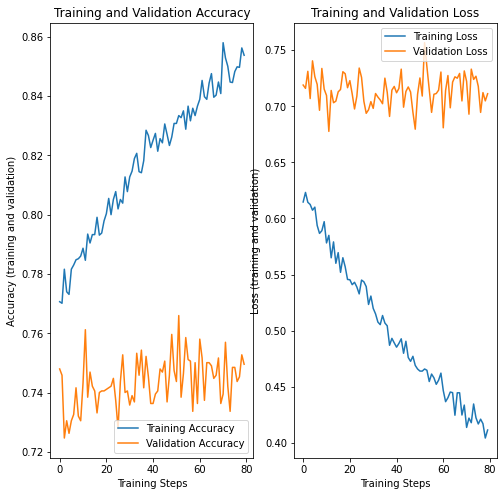

In [ ]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

# **Menyimpan Model**



Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: /tmp/saved_models/1596167327/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1596167327/assets


'/tmp/saved_models/1596167327'

In [ ]:
# Now confirm that we can reload it, and it still gives the same results
reloaded = tf.keras.models.load_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})

In [ ]:
# convert the model to TFLite
!mkdir "tflite_models"
TFLITE_MODEL = "tflite_models/plant_disease_model2.tflite"


# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : reloaded(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# Convert the model to standard TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

11481832

In [ ]:
model.save('/content/drive/My Drive/Cassava/casfix.h5')

# **Menguji Model Dengan Data Test**



In [ ]:
import json

with open('/content/drive/My Drive/Cassava/categories.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())
    
print (classes)

['cbb', 'cmd', 'cgm', 'cbsd', 'healthy']


In [ ]:
# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    img = cv2.imread(os.path.join(base_dir,test_dir, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    # img = cv2.resize(img, (50,50) )
    img = img /255
    
    return img

def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

In [ ]:
for idx, filename in enumerate(random.sample(test_generator.filenames, 10)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/My Drive/Cassava/casfix.h5',custom_objects={'KerasLayer':hub.KerasLayer})
# reloaded = tf.keras.models.load_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})
C1 = ["cbb","cbsd","cgm","cmd","healthy"]

In [ ]:
# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    img = cv2.imread(os.path.join(base_dir,test_dir, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    
    return img


def predict(image):
    probabilities = new_model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: healthy, file: healthy/test-healthy-102.jpg
PREDICTED: class: healthy, confidence: 0.896221


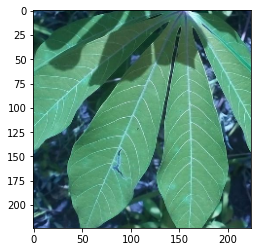

<Figure size 432x288 with 0 Axes>

In [ ]:
for idx, filename in enumerate(test_generator.filenames [1791:1792]):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [ ]:
import numpy as np
test_steps_per_epoch = np.math.ceil(test_generator.n /test_generator.batch_size )
predictions = model.predict_generator(test_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

Instructions for updating:
Please use Model.predict, which supports generators.


Instructions for updating:
Please use Model.predict, which supports generators.


In [ ]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   

In [ ]:
import sklearn.metrics as metrics
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

         cbb       0.52      0.44      0.47       155
        cbsd       0.76      0.72      0.74       481
         cgm       0.70      0.63      0.66       258
         cmd       0.86      0.89      0.87       892
     healthy       0.59      0.83      0.69       105

    accuracy                           0.77      1891
   macro avg       0.68      0.70      0.69      1891
weighted avg       0.77      0.77      0.77      1891



In [ ]:
STEP_SIZE_TEST=test_generator1.n//test_generator1.batch_size + 1
test_generator1.reset()
pred=model.predict_generator(test_generator1,
                steps=STEP_SIZE_TEST,
                verbose=1)

55/55 [==============================] - 2051s 37s/step


In [ ]:
predicted_class_indices=np.argmax(pred,axis=1)

In [ ]:
len(predicted_class_indices)

3783

In [ ]:
predicted_class_indices[:10]

array([1, 1, 3, 2, 1, 3, 3, 3, 3, 2])

In [ ]:
import pandas as pd
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions1 = [labels[k] for k in predicted_class_indices]
filenames=test_generator1.filenames
results=pd.DataFrame({"Category":predictions1,
                      "id":filenames})

In [ ]:
results.head()

,Category,id
0,cbsd,test/test-img-0.jpg
1,cbsd,test/test-img-1.jpg
2,cmd,test/test-img-10.jpg
3,cgm,test/test-img-100.jpg
4,cbsd,test/test-img-1000.jpg


In [ ]:
results.Category.value_counts()

cmd        1852
cbsd        897
cgm         484
healthy     281
cbb         269
Name: Category, dtype: int64

In [ ]:
results.loc[:,'id'] = results.id.str.replace('0/','')

In [ ]:
results.head()

,Category,id
0,cbsd,test/test-img-0.jpg
1,cbsd,test/test-img-1.jpg
2,cmd,test/test-img-10.jpg
3,cgm,test/test-img-100.jpg
4,cbsd,test/test-img-1000.jpg


In [ ]:
results.to_csv("submission.csv",index=False)